In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('Clustering_dataset.xlsx')

print("Data Shape:")
print(df.shape)

print("Data Preview:")
print(df.head())

print("Data Summary:")
print(df.describe())

Data Shape:
(200, 5)
Data Preview:
   CustomerID   Genre   Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male  19.0                15.0                    39.0
1           2    Male  21.0                 NaN                    81.0
2           3  Female  20.0                16.0                     6.0
3           4  Female  23.0                16.0                    77.0
4           5  Female  31.0                17.0                    40.0
Data Summary:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  194.000000          194.000000              194.000000
mean   100.500000   38.731959           60.814433               50.350515
std     57.879185   14.019243           26.394901               26.176183
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.250000           40.500000               34.250000
50%    100.500000   36.000000           62.000000               50.000000
7

In [7]:
# Encode Genre 
df['Genre'] = df['Genre'].map({'Male': 0, 'Female': 1})

# Drop rows with ANY NaN across all columns cause doing just the average might not be good for 
# clustering as we will be putting some values without knowing any realtion between them.
before = len(df)

df = df.dropna(axis=0, how='any').reset_index(drop=True)

print(f"Removed {before - len(df)} rows with NaN.")

# Dropping CustomerID as it is not useful for clustering
X = df.drop(columns=['CustomerID']).to_numpy(dtype=float)

Removed 22 rows with NaN.


In [8]:

class GMM:
    def __init__(self, k=3, max_iters=200, tol=1e-4, reg_covar=1e-6, verbose=False):
        self.k = int(k)
        self.max_iters = int(max_iters)
        self.tol = float(tol)
        self.reg_covar = float(reg_covar)
        self.verbose = verbose

        self.pi_ = None          # (k,)
        self.mu_ = None          # (k,d)
        self.Sigma_ = None       # (k,d,d)
        self.lkh_history_ = []   # list of log-likelihoods

    # ---------- vectorized helpers ----------
    def _log_gaussians(self, X):
        """
        Return log N(x_i | mu_k, Sigma_k) for all i,k as (n,k).
        Uses batched slogdet and batched inverse + einsum for Mahalanobis.
        """
        X = np.asarray(X, float)             # (n,d)
        n, d = X.shape
        k = self.k

        # Regularize covariances
        regI = self.reg_covar * np.eye(d)
        Sigma = self.Sigma_ + regI[None, :, :]     # (k,d,d)

        # log |Sigma_k|
        sign, logdet = np.linalg.slogdet(Sigma)    # (k,)
        # Sigma_k^{-1}

        Sigma_inv = np.linalg.inv(Sigma)           # (k,d,d)
        # diffs: (n,k,d)
        diff = X[:, None, :] - self.mu_[None, :, :]

        # Mahalanobis: (x-mu)^T Sigma^{-1} (x-mu)  -> (n,k)
        quad = np.einsum('nkd,kde,nke->nk', diff, Sigma_inv, diff)

        log_norm = -0.5 * (d * np.log(2*np.pi) + logdet[None, :] + quad)
        return log_norm  # (n,k)

    def _logsumexp(self, A, axis=1):
        m = np.max(A, axis=axis, keepdims=True)
        return (m + np.log(np.sum(np.exp(A - m), axis=axis, keepdims=True))).squeeze(axis)

    def _e_step(self, X):
        """
        Compute responsibilities gamma (n,k) and total log-likelihood (scalar).
        """
        log_pdf = self._log_gaussians(X)                 # (n,k)
        log_mix = np.log(self.pi_)[None, :]              # (1,k)
        log_joint = log_pdf + log_mix                    # (n,k)

        log_sum = self._logsumexp(log_joint, axis=1)     # (n,)
        ll = float(np.sum(log_sum))                      # total log-likelihood

        # gamma = exp(log_joint - log_sum[:,None])
        gamma = np.exp(log_joint - log_sum[:, None])     # (n,k)
        return gamma, ll

    def _m_step(self, X, gamma):
        """
        Update pi_, mu_, Sigma_ from responsibilities. Vectorized.
        """
        n, d = X.shape
        Nk = gamma.sum(axis=0)                           # (k,)
        Nk_safe = np.clip(Nk, 1e-12, None)

        # means (k,d): (gamma^T X) / Nk
        self.mu_ = (gamma.T @ X) / Nk_safe[:, None]

        # covariances: sum_i gamma_{ik} (x_i - mu_k)(x_i - mu_k)^T / Nk
        diff = X[:, None, :] - self.mu_[None, :, :]      # (n,k,d)
        # (k,d,d) via einsum over n with weights gamma
        self.Sigma_ = np.einsum('nk,nkd,nke->kde', gamma, diff, diff) / Nk_safe[:, None, None]
        # regularize a bit (kept small; main regularization added in _log_gaussians)
        self.Sigma_ += self.reg_covar * np.eye(d)[None, :, :]

        # mixture weights
        self.pi_ = Nk_safe / n

    def _init_params(self, X):
        """
        Simple init: pick k random rows as means; uniform pi; diagonal cov from data.
        """
        n, d = X.shape
        idx = np.random.choice(n, self.k, replace=False)
        self.mu_ = X[idx].astype(float)                  # (k,d)
        # diagonal covariance from data variance
        var = np.var(X, axis=0) + self.reg_covar
        self.Sigma_ = np.tile(np.diag(var)[None, :, :], (self.k, 1, 1))  # (k,d,d)
        self.pi_ = np.ones(self.k, dtype=float) / self.k
        self.lkh_history_ = []

    # ---------- public API ----------
    def fit(self, X):
        """
        EM for GMM.
        Stores log-likelihood per iteration in lkh_history_.
        """
        X = np.asarray(X, float)
        if X.ndim != 2:
            print("fit: X must be 2D.")
            return self

        self._init_params(X)
        prev_ll = -np.inf

        for it in range(self.max_iters):  # iteration loop only
            gamma, ll = self._e_step(X)
            self._m_step(X, gamma)
            self.lkh_history_.append(ll)

            if self.verbose:
                print(f"iter {it:3d} | loglik {ll:.6f}")

            if np.isfinite(prev_ll) and (ll - prev_ll) < self.tol:
                break
            prev_ll = ll
        return self

    def getMembership(self, X):
        """Return responsibilities gamma_{ic} (n,k)."""
        X = np.asarray(X, float)
        gamma, _ = self._e_step(X)
        return gamma

    def getLikelihood(self, X):
        """Return total log-likelihood of X under current parameters."""
        X = np.asarray(X, float)
        _, ll = self._e_step(X)
        return ll

    def drawLikelihood(self):
        """Plot log-likelihood vs iteration from the last fit."""
        if not self.lkh_history_:
            print("drawLikelihood: fit the model first.")
            return
        plt.figure(figsize=(6,4))
        plt.plot(np.arange(1, len(self.lkh_history_)+1), self.lkh_history_, marker='o')
        plt.xlabel("Iteration")
        plt.ylabel("Log-Likelihood")
        plt.title(f"GMM (k={self.k}) — Log-Likelihood vs Iterations")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.show()


Memberships shape: (178, 3)
Total log-likelihood: -2417.040243809064


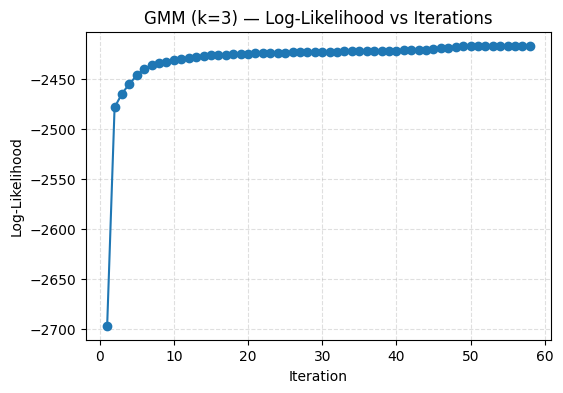

Cluster sizes: {0: 45, 1: 37, 2: 96}


In [ ]:
gmm = GMM(k=3, max_iters=200, tol=1e-4, reg_covar=1e-6, verbose=False).fit(X)

Gamma = gmm.getMembership(X)           # (n,k)
print("Memberships shape:", Gamma.shape)

print("Total log-likelihood:", gmm.getLikelihood(X))
gmm.drawLikelihood()

hard_labels = np.argmax(Gamma, axis=1)
unique, counts = np.unique(hard_labels, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))


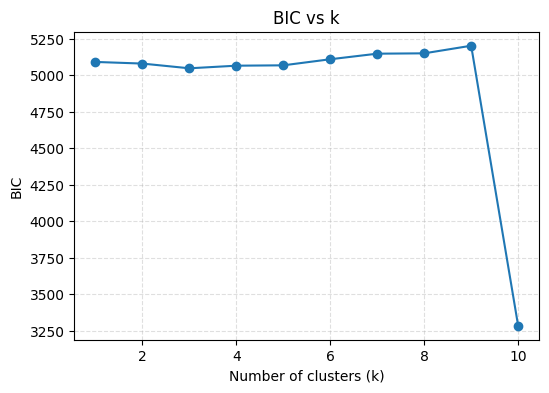

Optimal k according to BIC: 10


In [12]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

ks = range(1, 11)
bics = []

for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X)
    bics.append(gmm.bic(X))

plt.figure(figsize=(6,4))
plt.plot(ks, bics, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("BIC")
plt.title("BIC vs k")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

best_k_bic = ks[np.argmin(bics)]
print("Optimal k according to BIC:", best_k_bic)


The BIC values remained nearly constant for 𝑘=1 through 𝑘=9, suggesting that additional clusters do not improve the model fit significantly. A decrease in BIC was observed at 𝑘=10, but this likely reflects overfitting rather than a meaningful cluster structure. Based on this pattern, the data do not provide strong evidence for more than a few clusters, and the BIC criterion does not clearly identify an optimal 𝑘 other than indicating that small 𝑘 values are sufficien

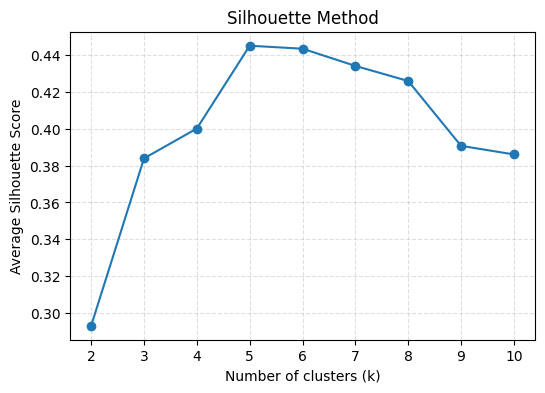

Optimal k according to Silhouette: 5


In [13]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np

ks = range(2, 11)
sil_scores = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Method")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

best_k_sil = ks[np.argmax(sil_scores)]
print("Optimal k according to Silhouette:", best_k_sil)


The silhouette scores increased with and reached their maximum at 𝑘 = 5. This indicates that five clusters provide the best balance of intra-cluster cohesion and inter-cluster separation. Beyond five clusters, the silhouette score declined, showing that the clusters became less distinct

BIC is conservative: it penalizes overfitting, so it may recommend fewer clusters or stay flat unless there’s a big gain.

Silhouette is geometric: it can detect visually nice separations that don’t translate into a large statistical likelihood gain.

This difference is common:

BIC/likelihood-based criteria reflect the probabilistic modeling assumptions.

Silhouette reflects data geometry.